In [1]:
# Import

import epics
import numpy
import pandas
import torch
import nufft

import sys
sys.path.append('..')

from harmonica.util import LENGTH, QX, QZ
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


# Example-01: FFT amplitude spectrum

Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)))


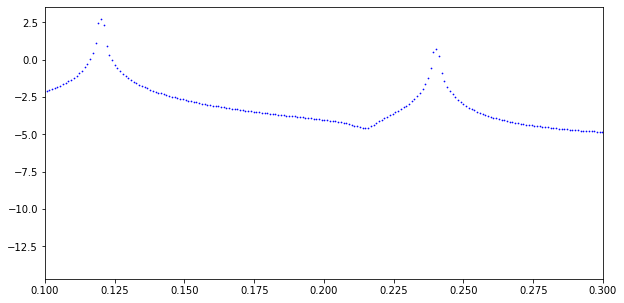

In [2]:
# Set parameters (64 signals with length 1024)
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(win)

# Set TbT data (64 signals with two components and different amplitudes)
t = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
tbt = Data.from_tensor(win, data)
print(tbt)

# Initialize Frequency instance
f = Frequency(tbt)
print(f)

# Apply window (note, window is applied to work, Frequency methods act on work)
f.data.window_remove_mean()
f.data.window_apply()

# FFT grid is stored in fft_grid (computed on initialization)
# FFT spectrum amplitudes are stored in fft_spectrum for each signal

# Compute FFT amplitude spectrum
f.fft_get_spectrum()

# Reset TbT work
f.data.reset()

# Plot (log10) FFT spectrum for given signal id
idx = 0
plt.figure(figsize=(10,5))
plt.scatter(f.fft_grid.cpu(), torch.log10(f.fft_spectrum[idx].cpu()), s=0.5, c='b')
plt.xlim(0.1, 0.3)
plt.show()

# Clean
del win
del tbt
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# Example-02: FFT amplitude spectrum & zero padding

Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)))


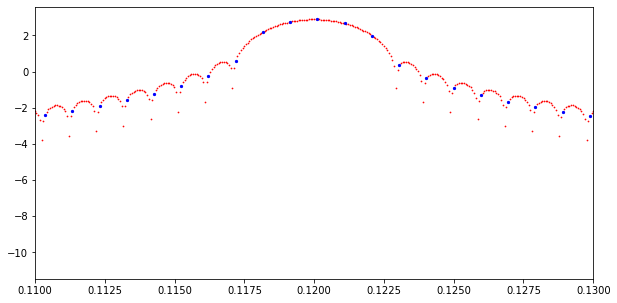

In [3]:
# Set parameters (64 signals with length 1024)
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(win)

# Set TbT data (64 signals with two components and different amplitudes)
t = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
tbt = Data.from_tensor(win, data)
print(tbt)

# If pad == 0, it is set to signal length
# Spectrum is computed using torch.fft.rfft(..., n=pad)
# Padding can be used to interpolate DTFT spectrum in all frequency range
# This improves frequency estimation accuracy (assuming frequency corresponds to max of the largest FFT spectrum amplitude peak)
# Can be used to obtain a better initial guess, if signal has several frequencies with close amplitudes

# Initialize Frequency instances with and without padding
f1 = Frequency(tbt, pad=length*2**4)
f2 = Frequency(tbt, pad=length*2**0)
print(f1)
print(f2)

# Apply window to data
f1.data.window_apply()
f2.data.window_apply()

# Compute FFT amplitude spectrum
f1.fft_get_spectrum()
f2.fft_get_spectrum()

# Reset TbT work
f1.data.reset()
f2.data.reset()

# Plot (log10) FFT spectrum for given signal id
idx = 0
plt.figure(figsize=(10,5))
plt.scatter(f1.fft_grid.detach().cpu(), torch.log10(f1.fft_spectrum[idx].detach().cpu()), s=0.5, c='r')
plt.scatter(f2.fft_grid.detach().cpu(), torch.log10(f2.fft_spectrum[idx].detach().cpu()), s=5.0, c='b')
plt.xlim(0.12 - 0.01, 0.12 + 0.01)
plt.show()

# Clean
del win
del tbt
del f1, f2
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# Example-03: FFT frequency estimation & zero padding

In [4]:
# FFT frequency estimation is based on location of max bin in the amplitude spectum

# Set parameters (64 signals with length 1024)
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(win)

# Set TbT data (64 signals with two components and different amplitudes)
t = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
tbt = Data.from_tensor(win, data)
print(tbt)

# Initialize Frequency instances with and without padding
f1 = Frequency(tbt, pad=length*2**0)
f2 = Frequency(tbt, pad=length*2**4)
print(f1)
print(f2)

# Estimate frequency
f1('fft')
f2('fft')

# Compare results
print(torch.min(f1.frequency - 0.12))
print(torch.min(f2.frequency - 0.12))

# In this case call invokes task_fft method
f1.task_fft(window=True)
f2.task_fft(window=True)

# Clean
del win
del tbt
del f1, f2
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)))
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(-4.882812499996e-06, dtype=torch.float64)


# Example-04: FFT frequency estimation & zero padding for given range

In [5]:
# Set parameters (64 signals with length 1024)
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(win)

# Set TbT data (64 signals with two components and different amplitudes)
t = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
tbt = Data.from_tensor(win, data)
print(tbt)

# Initialize Frequency instances with and without padding
f1 = Frequency(tbt, pad=length*2**0)
f2 = Frequency(tbt, pad=length*2**4)
print(f1)
print(f2)

# By default FFT frequency estimation is performed using (0.0, 0.5) frequency range.
# Explicit range can be passed.

# Estimate frequency for explicit frequency range
f1('fft', f_range=(0.2, 0.25))
f2('fft', f_range=(0.2, 0.25))

# Compare results
print(torch.min(f1.frequency - 0.24))
print(torch.min(f2.frequency - 0.24))

# Clean
del win
del tbt
del f1, f2
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)))
tensor(2.343750000000e-04, dtype=torch.float64)
tensor(-9.765624999991e-06, dtype=torch.float64)


# Example-05: FFRFT/ZOOM amplitude spectrum

Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)))
tensor([1.191406250000e-01, 1.210918426514e-01], dtype=torch.float64)
tensor([1.191406250000e-01, 1.210937500000e-01], dtype=torch.float64)
tensor([1.191406250000e-01, 1.210937500000e-01], dtype=torch.float64)


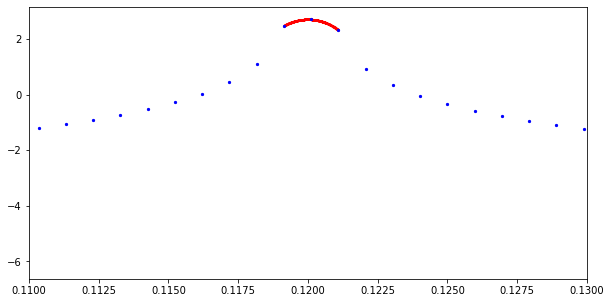

tensor([1.150000000000e-01, 1.249902343750e-01], dtype=torch.float64)
tensor([1.150000000000e-01, 1.250000000000e-01], dtype=torch.float64)


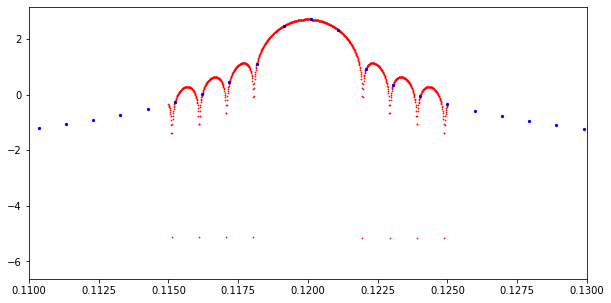

In [6]:
# FFRFT can be used for local DTFT spectrum interpolation

# Set parameters (64 signals with length 1024)
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(win)

# Set TbT data (64 signals with two components and different amplitudes)
t = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
tbt = Data.from_tensor(win, data)
print(tbt)

# Initialize Frequency instance
f = Frequency(tbt)
print(f)

# Apply window to data
f.data.window_apply()

# Compute FFT amplitude spectrum
f.fft_get_spectrum()

# By default for FFRFT spectrum, FFT frequency estimation is used
# And frequency range is equal to 2 FFT bins around max FFT bin
# This can be changed by setting fraction parameter on initialization
# Or by setting ffrft_span attibute directry after initialization
# Use default value.
f.ffrft_span = 2.0/f.length

# If ffrft_flag is False, ffrft_initialize_spectrum is invoked
# ffrft_flag is set to True, futher calls do not reinitialize FFRFT
# No need to initialize for fixed signal length

# Compute FFT frequency estimation (used to define FFRFT frequency center)
f.fft_get_frequency()

# Compute FFRFT amplitude spectrum
f.ffrft_get_spectrum()

# Note, last point is not included
print(torch.stack([f.ffrft_get_grid(0)[0], f.ffrft_get_grid(0)[-1]]))
print(torch.stack([f.ffrft_get_grid(0)[0], f.ffrft_get_grid(0)[-1] + f.ffrft_span*f.fft_step]))
print(torch.stack([f.fft_frequency[0] - f.fft_step, f.fft_frequency[0] + f.fft_step]))

# Plot (log10) FFT spectrum for given signal id
idx = 0
plt.figure(figsize=(10,5))
plt.scatter(f.ffrft_get_grid(idx).cpu(), torch.log10(f.ffrft_spectrum[idx].cpu()), s=0.5, c='r')
plt.scatter(f.fft_grid.cpu(), torch.log10(f.fft_spectrum[idx].cpu()), s=5.0, c='b')
plt.xlim(0.12 - 0.01, 0.12 + 0.01)
plt.show()

# FFRFT can be used with custom range
# In this case all signals share this range, while for the default case, each signal range is defined by its FFT frequency
# In all cases range length is the same for all signals

# Compute FFRFT amplitude spectrum with custom range
# Range (f_min, f_max) = (center - 0.5*span, center + 0.5*span - span/length)
f.ffrft_get_spectrum(center=0.12, span=0.01)

# Note, last point is not included
print(torch.stack([f.ffrft_get_grid(0)[0], f.ffrft_get_grid(0)[-1]]))
print(torch.stack([f.ffrft_get_grid(0)[0], f.ffrft_get_grid(0)[-1] + f.ffrft_span*f.fft_step]))

# Plot (log10) FFT spectrum for given signal id
idx = 0
plt.figure(figsize=(10,5))
plt.scatter(f.ffrft_get_grid(idx).cpu(), torch.log10(f.ffrft_spectrum[idx].cpu()), s=0.5, c='r')
plt.scatter(f.fft_grid.cpu(), torch.log10(f.fft_spectrum[idx].cpu()), s=5.0, c='b')
plt.xlim(0.12 - 0.01, 0.12 + 0.01)
plt.show()

# Clean
del win
del tbt
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# Example-06: FFRFT/ZOOM frequency estimation

In [7]:
# FFRFT frequency estimation is based on local DTFT spectrum interpolation (near expected global maximum)
# By default refined spectum is computed inside two FFT bins around maximum bin
# In this case expected frequency error is proportional to 1/n^2

# Set parameters (64 signals with length 1024)
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(win)

# Set TbT data (64 signals with two components and different amplitudes)
t = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
tbt = Data.from_tensor(win, data)
print(tbt)

# Initialize Frequency instance
f1 = Frequency(tbt)
f2 = Frequency(tbt, fraction=1.0)
print(f1)
print(f2)

# Fraction between 1.0-2.0 should be save to use

# Estimate frequency, see also task_ffrft
f1('ffrft')
f2('ffrft')

# Compare results FFT & FFRFT estimations
print(torch.min(f1.fft_frequency - 0.12))
print(torch.min(f2.fft_frequency - 0.12))
print(torch.min(f1.ffrft_frequency - 0.12))
print(torch.min(f2.ffrft_frequency - 0.12))

# Clean
del win
del tbt
del f1, f2
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)))
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(8.392333984419e-07, dtype=torch.float64)
tensor(-1.144409179643e-07, dtype=torch.float64)


# Example-07: Parabola frequency estimation

In [8]:
# Parabola frequency estimation is based on parabolic interpolation of FFRFT amplitude spectrum
# Three points are used to locate parabola maximum (FFRFT max bin and two poins around it)
# Higher order polynomial can be used or a gradient free bracketing maximum search
# Instead of interpolation, a polynomial (e.g. a parabola) can be fitted near the peak maximum
# Without noise, parabolic interpolation significantly improves estimation accuracy
# Window order impoves accuracy in this case too (flat top)
# With noise accuracy gain from parabolic interpolation decreases
# Application of window increases noise

# Set parameters (64 signals with length 1024)
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(win)

# Set TbT data (64 signals with two components and different amplitudes)
t = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
tbt = Data.from_tensor(win, data)
print(tbt)

# Initialize Frequency instance
f = Frequency(tbt)
print(f)

# Estimate frequency, see also task_parabola
f('parabola')

# Compare results
print(torch.mean(f.fft_frequency)-0.12)
print(torch.mean(f.ffrft_frequency)-0.12)
print(torch.mean(f.parabola_frequency)-0.12)

# Clean
del win
del tbt
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)))
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(8.392333984419e-07, dtype=torch.float64)
tensor(3.001190962415e-11, dtype=torch.float64)


# Example-08: Frequency vs signal start shift

Window(2048, 'cosine_window', 1.0)
Data(1, Window(2048, 'cosine_window', 1.0))
Data(1025, Window(1024, 'cosine_window', 1.0))
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(8.392333984419e-07, dtype=torch.float64)
tensor(-4.614364446098e-14, dtype=torch.float64)


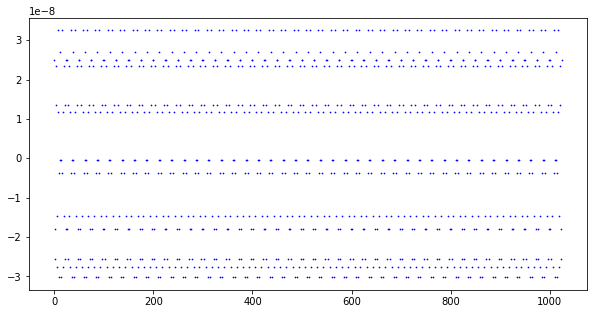

In [9]:
# Set parameters (1 signal with length 2048)
dtype, device = torch.float64, 'cpu'
size, length = 1, 2048

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(win)

# Set TbT data (1 signals with two components)
t = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
tbt = Data.from_tensor(win, data)
print(tbt)

# Generate matrix frim signal
tbt = tbt.make_matrix(0, 1024, 1, name='cosine_window', order=1.0)
print(tbt)

# Initialize Frequency instance
f = Frequency(tbt)

# Estimate frequency
f('parabola')
print(torch.mean(f.fft_frequency)-0.12)
print(torch.mean(f.ffrft_frequency)-0.12)
print(torch.mean(f.parabola_frequency)-0.12)

# Plot result
shift = torch.linspace(0, len(tbt)-1, len(tbt))
plt.figure(figsize=(10,5))
plt.scatter(shift, (f.parabola_frequency.cpu()-0.12)/0.12 * 100, s=0.5, c='b')
plt.show()

# Clean
del win
del tbt
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# Example-09: Frequency vs signal start shift (noise)

Window(8192, 'cosine_window', 1.0)
Data(1, Window(8192, 'cosine_window', 1.0))
Data(7169, Window(1024, 'cosine_window', 1.0))
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(9.507743164994e-08, dtype=torch.float64)
tensor(-1.294518271744e-08, dtype=torch.float64)


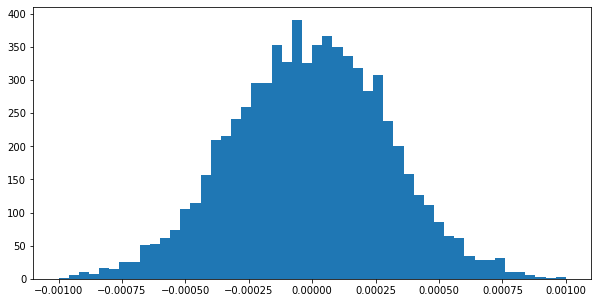

In [10]:
# Set parameters (1 signal with length 8192)
dtype, device = torch.float64, 'cpu'
size, length = 1, 8192

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(win)

# Set TbT data (1 signals with two components)
t = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
tbt = Data.from_tensor(win, data)
print(tbt)

# Generate matrix frim signal
tbt = tbt.make_matrix(0, 1024, 1, name='cosine_window', order=1.0)
print(tbt)

# Add noise to each signal
for i in range(tbt.size):
    tbt.data[i] += 0.01*torch.randn(tbt.length, dtype=dtype, device=device)
tbt.reset()

# Initialize Frequency instance
f = Frequency(tbt)

# Estimate frequency
f('parabola', window=True)
print(torch.mean(f.fft_frequency)-0.12)
print(torch.mean(f.ffrft_frequency)-0.12)
print(torch.mean(f.parabola_frequency)-0.12)

# Plot result
plt.figure(figsize=(10,5))
plt.hist((f.parabola_frequency.cpu().numpy()-0.12)/0.12 * 100, bins=50, range=(-0.001, 0.001))
plt.show()

# Clean
del win
del tbt
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# Example-10: Frequency vs signal start shift (correlated noise)

Window(8192, 'cosine_window', 1.0)
Data(1, Window(8192, 'cosine_window', 1.0))
Data(7169, Window(1024, 'cosine_window', 1.0))
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(2.336921111901e-07, dtype=torch.float64)
tensor(9.017344135276e-09, dtype=torch.float64)


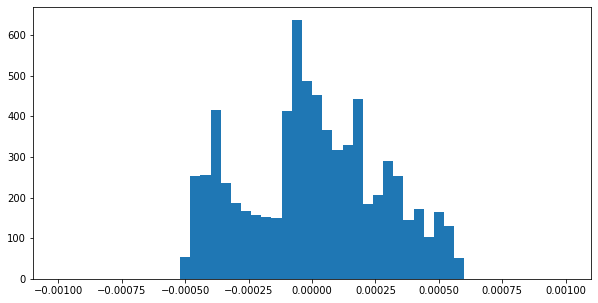

In [11]:
# Set parameters (1 signal with length 8192)
dtype, device = torch.float64, 'cpu'
size, length = 1, 8192

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(win)

# Set TbT data (1 signals with two components and random noise)
t = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
data += 0.01*torch.randn(length, dtype=dtype, device=device)
tbt = Data.from_tensor(win, data)
print(tbt)

# Generate matrix frim signal
tbt = tbt.make_matrix(0, 1024, 1, name='cosine_window', order=1.0)
print(tbt)

# Initialize Frequency instance
f = Frequency(tbt)

# Estimate frequency
f('parabola', window=True)
print(torch.mean(f.fft_frequency)-0.12)
print(torch.mean(f.ffrft_frequency)-0.12)
print(torch.mean(f.parabola_frequency)-0.12)

# Plot result
plt.figure(figsize=(10,5))
plt.hist((f.parabola_frequency.cpu().numpy()-0.12)/0.12 * 100, bins=50, range=(-0.001, 0.001))
plt.show()

# Clean
del win
del tbt
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# Example-11: Iterative decomposition

In [12]:
# Set parameters
dtype, device = torch.float64, 'cpu'
size, length = 1, 1024

# Set window
win = Window.from_cosine(length, order=4.0, dtype=dtype, device=device)

# Set data
t  = torch.linspace(1.0, length, length, dtype=dtype, device=device)
data  = 1.0000*torch.cos(2.0*numpy.pi*1*0.12*t) + 0.10000*torch.sin(2.0*numpy.pi*1*0.12*t)
data += 0.0050*torch.cos(2.0*numpy.pi*2*0.12*t) + 0.01000*torch.sin(2.0*numpy.pi*2*0.12*t)
data += 0.0001*torch.cos(2.0*numpy.pi*3*0.12*t) + 0.00001*torch.sin(2.0*numpy.pi*3*0.12*t)
data += 2.0
data  = torch.stack([data])

tbt = Data.from_tensor(win, data)

# Compute (window weighted) mean value
print(tbt.window_mean().flatten().cpu().numpy())

# Remove (window weighted) mean value
# Note, mean is removed from work
tbt.window_remove_mean()
tbt.data.copy_(tbt.work)

# Initialize Frequency instance
f = Frequency(tbt)

# Perform decomposition (component-by-component subtraction)
for _ in range(3):
    f('parabola')
    frequency = f.frequency[0]
    c_amp = 2.0*torch.dot(tbt[0]*win.data, torch.cos(2.0*numpy.pi*frequency*t))/win.total
    s_amp = 2.0*torch.dot(tbt[0]*win.data, torch.sin(2.0*numpy.pi*frequency*t))/win.total
    print(torch.stack([frequency, c_amp, s_amp]).cpu().numpy())
    rem = c_amp*torch.cos(2.0*numpy.pi*frequency*t) + s_amp*torch.sin(2.0*numpy.pi*frequency*t)
    tbt.data.sub_(rem)
    tbt.reset()

# Residual norm
print(torch.sum(torch.sqrt(tbt.data**2)).item())

# Clean
del win
del tbt
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

[2.]
[0.12 1.   0.1 ]
[0.24  0.005 0.01 ]
[3.6e-01 1.0e-04 1.0e-05]
5.759385082140556e-09


# Example-12: Mixed frequency (direct)

In [13]:
# Set window
device = 'cpu'
win = Window(4096, name='cosine_window', order=1.0, dtype=torch.float64, device=device)

# Load test TbT data from file (linear lattice without noise)
tbt = Data.from_file(54, win, '../virtual_tbt.npy')

# Compute frequencies for each BPM
f = Frequency(tbt)
print(f)
f('parabola')

# Compute mean and standart deviation
f1 = f.frequency.mean()
s1 = f.frequency.std()
print(f1.item())
print(s1.item())

# Generate mixed signal using first 64 turns and all signals
# Mixed signal is generated from work container
tbt = tbt.make_signal(64, name='cosine_window', order=1.0)

# Compute frequency from mixed signal
f = Frequency(tbt)
print(f)
f('parabola', f_range=(8.5/54, 8.6/54))
f2 = 1.0 - (54*f.frequency.mean() - 8.0)
print(f2.item())

# Compare
print(f1.item() - f2.item())

# Clean
del win
del tbt
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Frequency(Data(54, Window(4096, 'cosine_window', 1.0)))
0.461485904416196
1.1758247157674714e-13
Frequency(Data(1, Window(3456, 'cosine_window', 1.0)))
0.4614880139297153
-2.109513519255035e-06


# Example-13: Mean spectrum

Window(4096, 'cosine_window', 1.0)
Data(54, Window(4096, 'cosine_window', 1.0))
Frequency(Data(54, Window(4096, 'cosine_window', 1.0)))


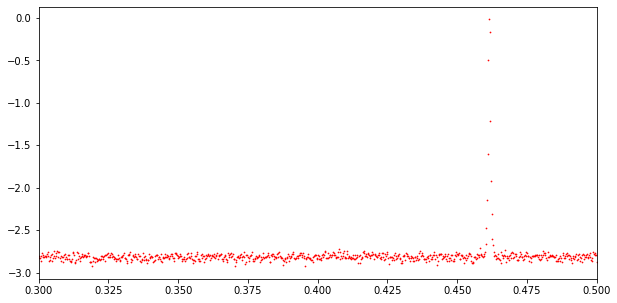

In [14]:
# Set window
device = 'cpu'
win = Window(4096, name='cosine_window', order=1.0, dtype=torch.float64, device=device)
print(win)

# Load TbT data from file and add noise
tbt = Data.from_file(54, win, '../virtual_tbt.npy')
std = 1.0E-4 * torch.ones(54, dtype=torch.float64)
Data.add_noise(tbt.data, std)
tbt.reset()
print(tbt)

# Initialize Frequency instance
f = Frequency(tbt)
print(f)

# Compute frequencies
# These frequencies are used for normalization of each signal spectrum
f('parabola', window=True)

# Compute mean spectrum
# Note, here window flag is used in normalization, spectra are not recomputed
grid, spectrum = f.task_mean_spectrum(window=True, log=True)

# Plot mean spectrum
plt.figure(figsize=(10,5))
plt.xlim(0.3, 0.5)
plt.scatter(grid.cpu(), spectrum.cpu(), s=0.5, c='r')
plt.show()

# Clean
del win
del tbt
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# Example-14: Mixed spectrum

Window(4096, 'cosine_window', 1.0)
Data(54, Window(4096, 'cosine_window', 1.0))
Frequency(Data(54, Window(4096, 'cosine_window', 1.0)))


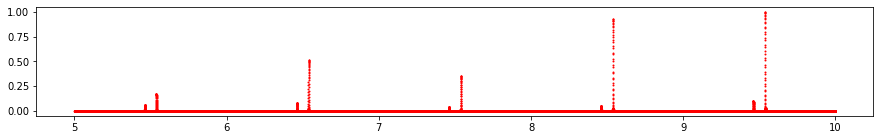

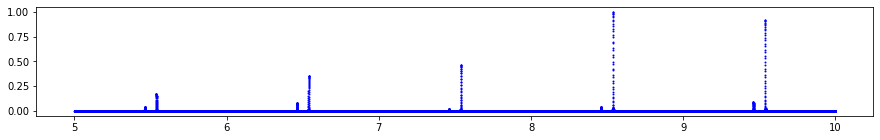

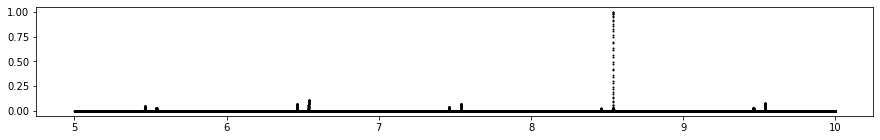

In [15]:
# Load model data
df = pandas.read_json('../bpm.json')

# Set scaled positions (used as locations with NUFFT)
position = numpy.array([df[name]['S'] for name in df])/LENGTH

# Set scaled accumulated phase advance (used as locations with NUFFT)
phase = numpy.array([df[name]['FX'] for name in df])
phase = numpy.cumsum(phase)/(2.0*numpy.pi*QX)
start, *_ = phase
phase = phase - start

# Set window
device = 'cpu'
win = Window(4096, name='cosine_window', order=1.0, dtype=torch.float64, device=device)
print(win)

# Load TbT data from file and add noise
tbt = Data.from_file(54, win, '../virtual_tbt.npy')
std = 1.0E-4 * torch.ones(54, dtype=torch.float64)
Data.add_noise(tbt.data, std)
tbt.reset()
print(tbt)

# Initialize Frequency instance
f = Frequency(tbt)
print(f)

# Compute & plot mixed spectrum
f_range=(5.0, 10.0)
s1 = f.task_mixed_spectrum(length=1024, window=True, normalize=True, f_range=f_range)
s2 = f.task_mixed_spectrum(length=1024, window=True, normalize=True, f_range=f_range, position=position)
s3 = f.task_mixed_spectrum(length=1024, window=True, normalize=True, f_range=f_range, position=phase)
plt.figure(figsize=(15,2))
plt.scatter(*s1, c='red', s=1)
plt.show()
plt.figure(figsize=(15,2))
plt.scatter(*s2, c='blue', s=1)
plt.show()
plt.figure(figsize=(15,2))
plt.scatter(*s3, c='black', s=1)
plt.show()

# Clean
del win
del tbt
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
    
# s1 -- (red)   pre-normalized mixed signal treated as if it is uniformly sampled
# s2 -- (blue)  pre-normalized mixed signal and type-iii nufft with BPM position as location
# s3 -- (black) pre-normalized mixed signal and type-iii nufft with BPM phase as location

# As it can be seen, here s1 gives wrong integer part (peak with maximum amplitude)
# But this is not always the case

# Normalization is performed prio to mixing to make mixed signal closer to a stationary one
# Another option to reduce the effect of signal being non-stationary is to scale it with beta function
# Or to remove BPMs where amplitudes are not close enough

# Example-15: Mixed frequency (task, without noise)

In [16]:
# Load model data
df = pandas.read_json('../bpm.json')

# Set scaled positions (used as locations with NUFFT)
position = numpy.array([df[name]['S'] for name in df])/LENGTH

# Set scaled accumulated phase advance (used as locations with NUFFT)
phase = numpy.array([df[name]['FX'] for name in df])
phase = numpy.cumsum(phase)/(2.0*numpy.pi*QX)
start, *_ = phase
phase = phase - start

# Set window
win = Window(4096, name='cosine_window', order=1.0, dtype=torch.float64, device='cpu')
print(win)

# Load TbT data from file and add noise
tbt = Data.from_file(54, win, '../virtual_tbt.npy')

# Initialize Frequency instance
f = Frequency(tbt)
print(f)

# Compute reference frequency
f('parabola')
mean = torch.mean(f.frequency).item()
std = torch.std(f.frequency).item()
print(1-mean+8)
print(std)

# Compute mixed frequencies in given range
# Note, for small number of turns, result might be more accurate without window
# For large number of turns 'uniform' case is more accurate (might be a numerical problem)

length = 8
f1 = f.task_mixed_frequency(length=length, window=False, f_range=(8,9), normalize=True)
f2 = f.task_mixed_frequency(length=length, window=False, f_range=(8,9), normalize=True, position=position)
f3 = f.task_mixed_frequency(length=length, window=False, f_range=(8,9), normalize=True, position=phase)
print(f1.cpu().numpy())
print(f2.cpu().numpy())
print(f3.cpu().numpy())
print((1-(f1[-1]-8)-mean).item())
print((1-(f2[-1]-8)-mean).item())
print((1-(f3[-1]-8)-mean).item())

length = 32
f1 = f.task_mixed_frequency(length=length, window=True, f_range=(8,9), normalize=True)
f2 = f.task_mixed_frequency(length=length, window=True, f_range=(8,9), normalize=True, position=position)
f3 = f.task_mixed_frequency(length=length, window=True, f_range=(8,9), normalize=True, position=phase)
print(f1.cpu().numpy())
print(f2.cpu().numpy())
print(f3.cpu().numpy())
print((1-(f1[-1]-8)-mean).item())
print((1-(f2[-1]-8)-mean).item())
print((1-(f3[-1]-8)-mean).item())

length = 1024
f1 = f.task_mixed_frequency(length=length, window=True, f_range=(8,9), normalize=True)
f2 = f.task_mixed_frequency(length=length, window=True, f_range=(8,9), normalize=True, position=position)
f3 = f.task_mixed_frequency(length=length, window=True, f_range=(8,9), normalize=True, position=phase)
print(f1.cpu().numpy())
print(f2.cpu().numpy())
print(f3.cpu().numpy())
print((1-(f1[-1]-8)-mean).item())
print((1-(f2[-1]-8)-mean).item())
print((1-(f3[-1]-8)-mean).item())

Window(4096, 'cosine_window', 1.0)
Frequency(Data(54, Window(4096, 'cosine_window', 1.0)))
8.538514095583803
1.1758247157674714e-13
[8.5        8.53240741 8.53245579]
[8.47916667 8.53298611 8.53285945]
[8.47916667 8.53761574 8.53746483]
0.006058308980022187
0.005654646820478615
0.0010492665950828095
[8.53125    8.53855613 8.53854627]
[8.53877315 8.53851997 8.53853624]
[8.53877315 8.53851997 8.53851866]
-3.217357037071933e-05
-2.214332584776768e-05
-4.566388271232125e-06
[8.53808594 8.5385141  8.5385141 ]
[8.53851997 8.5385141  8.5385141 ]
[8.53851997 8.5385141  8.53851409]
1.1275258504639396e-11
-6.459017487525642e-09
6.212981074060764e-09


# Example-16: Mixed frequency (task, with noise)

In [17]:
# Load model data
df = pandas.read_json('../bpm.json')

# Set scaled positions (used as locations with NUFFT)
position = numpy.array([df[name]['S'] for name in df])/LENGTH

# Set scaled accumulated phase advance (used as locations with NUFFT)
phase = numpy.array([df[name]['FX'] for name in df])
phase = numpy.cumsum(phase)/(2.0*numpy.pi*QX)
start, *_ = phase
phase = phase - start

# Set window
win = Window(4096, name='cosine_window', order=1.0, dtype=torch.float64, device='cpu')
print(win)

# Load TbT data from file and add noise
tbt = Data.from_file(54, win, '../virtual_tbt.npy')
std = 1.0E-4 * torch.ones(54, dtype=torch.float64)
Data.add_noise(tbt.data, std)
tbt.reset()
print(tbt)

# Initialize Frequency instance
f = Frequency(tbt)
print(f)

# Compute reference frequency
f('parabola')
mean = torch.mean(f.frequency).item()
std = torch.std(f.frequency).item()
print(1-mean+8)
print(std)

# Compute mixed frequencies in given range
# Note, for small number of turns, result might be more accurate without window
# For large number of turns 'uniform' case is more accurate (might be a numerical problem)

length = 8
f1 = f.task_mixed_frequency(length=length, window=False, f_range=(8,9), normalize=True)
f2 = f.task_mixed_frequency(length=length, window=False, f_range=(8,9), normalize=True, position=position)
f3 = f.task_mixed_frequency(length=length, window=False, f_range=(8,9), normalize=True, position=phase)
print(f1.cpu().numpy())
print(f2.cpu().numpy())
print(f3.cpu().numpy())
print((1-(f1[-1]-8)-mean).item())
print((1-(f2[-1]-8)-mean).item())
print((1-(f3[-1]-8)-mean).item())

length = 32
f1 = f.task_mixed_frequency(length=length, window=True, f_range=(8,9), normalize=True)
f2 = f.task_mixed_frequency(length=length, window=True, f_range=(8,9), normalize=True, position=position)
f3 = f.task_mixed_frequency(length=length, window=True, f_range=(8,9), normalize=True, position=phase)
print(f1.cpu().numpy())
print(f2.cpu().numpy())
print(f3.cpu().numpy())
print((1-(f1[-1]-8)-mean).item())
print((1-(f2[-1]-8)-mean).item())
print((1-(f3[-1]-8)-mean).item())

length = 1024
f1 = f.task_mixed_frequency(length=length, window=True, f_range=(8,9), normalize=True)
f2 = f.task_mixed_frequency(length=length, window=True, f_range=(8,9), normalize=True, position=position)
f3 = f.task_mixed_frequency(length=length, window=True, f_range=(8,9), normalize=True, position=phase)
print(f1.cpu().numpy())
print(f2.cpu().numpy())
print(f3.cpu().numpy())
print((1-(f1[-1]-8)-mean).item())
print((1-(f2[-1]-8)-mean).item())
print((1-(f3[-1]-8)-mean).item())

Window(4096, 'cosine_window', 1.0)
Data(54, Window(4096, 'cosine_window', 1.0))
Frequency(Data(54, Window(4096, 'cosine_window', 1.0)))
8.538514087862284
1.7842488333799215e-07
[8.5        8.53298611 8.5328186 ]
[8.47916667 8.53298611 8.53319325]
[8.47916667 8.53761574 8.5375337 ]
0.005695486587606935
0.005320834385228734
0.0009803893279639042
[8.53125    8.53873698 8.53872317]
[8.53877315 8.53870081 8.53870203]
[8.53877315 8.53855613 8.5385714 ]
-0.00020908567752181417
-0.00018793935358368818
-5.730931651898308e-05
[8.53808594 8.53851435 8.53851435]
[8.53851997 8.53851407 8.53851405]
[8.53851997 8.53851378 8.53851379]
-2.6018180671050217e-07
3.4504990920058987e-08
2.990450305717651e-07


# Example-17: Mean spectrum (masked component)


Window(1024, 'cosine_window', 1.0)
Frequency(Data(128, Window(1024, 'cosine_window', 1.0)))


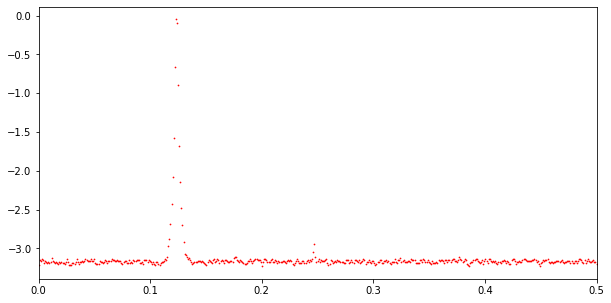

In [18]:
# Set window
device = 'cpu'
win = Window(1024, name='cosine_window', order=1.0, dtype=torch.float64, device=device)
print(win)

# Set data
t = torch.linspace(1.0, len(win), len(win), dtype=win.dtype)
data = torch.cos(2.0*numpy.pi*0.12345*t) + 1.E-3*torch.cos(2.0*numpy.pi*2.0*0.12345*t)
data = torch.stack([data + 1.E-2*torch.randn(len(win)) for _ in range(128)])

# Set TbT
tbt = Data.from_tensor(win, data)

# Initialize Frequency instance
f = Frequency(tbt)
print(f)

# Compute frequencies
f('parabola')

# Compute mean spectrum
grid, spectrum = f.task_mean_spectrum(window=True, log=True)

# Plot
plt.figure(figsize=(10,5))
plt.xlim(0.0, 0.5)
plt.scatter(grid.cpu(), spectrum.cpu(), s=0.5, c='r')
plt.show()

# Clean
del win
del tbt
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# Example-18: Non-uniform sampling

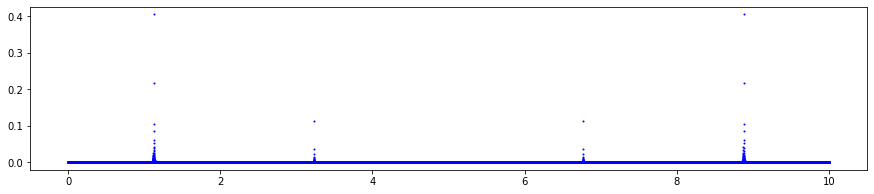

In [19]:
# Uniform sampling (stationary)

r = 10
l = 4096
t = torch.linspace(0.0, 1.0-1.0/r, r, dtype=torch.float64)
t = torch.cat([t + i for i in range(l)])

a = [1.0, 0.25]
f = [1.12345, 3.23456]
s = torch.sum(torch.stack([a[i]*torch.cos(2.0*numpy.pi*f[i]*t) for i in range(len(f))]), 0)

f_min, f_max = 0.0, 10.0
grid = 2.0*numpy.pi*numpy.linspace(f_min, f_max, len(t) + 1)
data = nufft.nufft1d3(t, s, grid)

plt.figure(figsize=(15, 3))
plt.scatter(grid/(2.0*numpy.pi), numpy.abs(data), c='b', s=1)
plt.show()

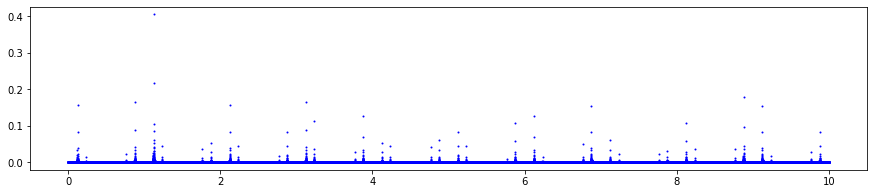

In [20]:
# Non-uniform periodic sampling (stationary)

r = 10
l = 4096
t = torch.sort(torch.rand(r, dtype=dtype)).values
t = torch.cat([t + i for i in range(l)])

a = [1.0, 0.25]
f = [1.12345, 3.23456]
s = torch.sum(torch.stack([a[i]*torch.cos(2.0*numpy.pi*f[i]*t) for i in range(len(f))]), 0)

f_min, f_max = 0.0, 10.0
grid = 2.0*numpy.pi*numpy.linspace(f_min, f_max, len(t) + 1)
data = nufft.nufft1d3(t, s, grid)

plt.figure(figsize=(15, 3))
plt.scatter(grid/(2.0*numpy.pi), numpy.abs(data), c='b', s=1)
plt.show()

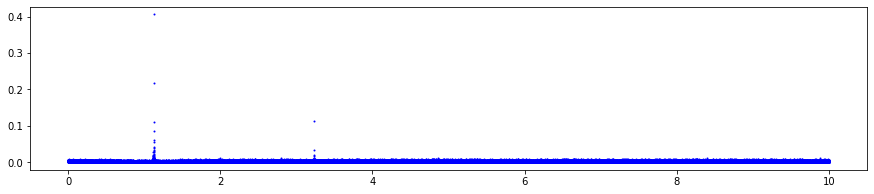

In [21]:
# Non-uniform random sampling (stationary)

r = 10
l = 4096
t = torch.cat([torch.sort(torch.rand(r, dtype=dtype)).values + i for i in range(l)])

a = [1.0, 0.25]
f = [1.12345, 3.23456]
s = torch.sum(torch.stack([a[i]*torch.cos(2.0*numpy.pi*f[i]*t) for i in range(len(f))]), 0)

f_min, f_max = 0.0, 10.0
grid = 2.0*numpy.pi*numpy.linspace(f_min, f_max, len(t) + 1)
data = nufft.nufft1d3(t, s, grid)

plt.figure(figsize=(15, 3))
plt.scatter(grid/(2.0*numpy.pi), numpy.abs(data), c='b', s=1)
plt.show()

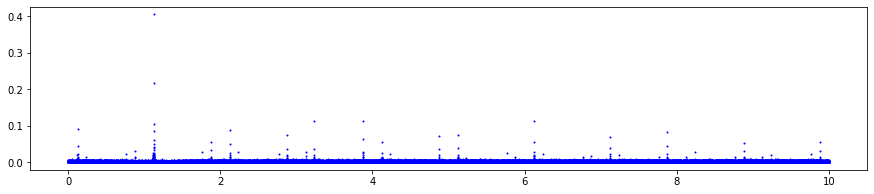

In [22]:
# Non-uniform periodic sampling with random choice (stationary)

c = 10
r = 5*10
l = 4096
t = torch.sort(torch.rand(r, dtype=dtype)).values
w = range(r)
t = torch.cat([torch.sort(t[numpy.random.choice(w, size=c, replace=False)]).values + i for i in range(l)])

a = [1.0, 0.25]
f = [1.12345, 3.23456]
s = torch.sum(torch.stack([a[i]*torch.cos(2.0*numpy.pi*f[i]*t) for i in range(len(f))]), 0)

f_min, f_max = 0.0, 10.0
grid = 2.0*numpy.pi*numpy.linspace(f_min, f_max, len(t) + 1)
data = nufft.nufft1d3(t, s, grid)

plt.figure(figsize=(15, 3))
plt.scatter(grid/(2.0*numpy.pi), numpy.abs(data), c='b', s=1)
plt.show()


# Example-19: Mixed frequency (threshold)

In [23]:
# Load model data
df = pandas.read_json('../bpm.json')

# Set scaled positions (used as locations with NUFFT)
position = numpy.array([df[name]['S'] for name in df])/LENGTH

# Set scaled accumulated phase advance (used as locations with NUFFT)
phase = numpy.array([df[name]['FX'] for name in df])
phase = numpy.cumsum(phase)/(2.0*numpy.pi*QX)
start, *_ = phase
phase = phase - start

# Set window
win = Window(4096, name='cosine_window', order=1.0, dtype=torch.float64, device='cpu')

# Load TbT data from file
tbt = Data.from_file(54, win, '../virtual_tbt.npy')

# Initialize Frequency instance
f = Frequency(tbt)
print(f)

# Compute reference frequency
f('parabola')
mean = torch.mean(f.frequency).item()
std = torch.std(f.frequency).item()

length = 32
f1 = f.task_mixed_frequency(length=length, window=True, f_range=(8,9), normalize=True)
f2 = f.task_mixed_frequency(length=length, window=True, f_range=(8,9), normalize=True, position=position)
f3 = f.task_mixed_frequency(length=length, window=True, f_range=(8,9), normalize=True, position=phase)
print((1-(f1[-1]-8)-mean).item())
print((1-(f2[-1]-8)-mean).item())
print((1-(f3[-1]-8)-mean).item())

Frequency(Data(54, Window(4096, 'cosine_window', 1.0)))
-3.217357037071933e-05
-2.214332584776768e-05
-4.566388271232125e-06


In [24]:
# Generate new TbT (threshold by max beta value)

cut = 50.0

# Load model data
df = pandas.read_json('../bpm.json')

# Set scaled positions (used as locations with NUFFT)
position = numpy.array([df[name]['S'] for name in df if df[name]['BX'] <= cut])/LENGTH

# Set scaled accumulated phase advance (used as locations with NUFFT)
phase = numpy.array([df[name]['FX'] for name in df if df[name]['BX'] <= cut])
phase = numpy.cumsum(phase)/(2.0*numpy.pi*QX)
start, *_ = phase
phase = phase - start

# Set window
win = Window(4096, name='cosine_window', order=1.0, dtype=torch.float64, device='cpu')

# Load TbT data from file
tbt = Data.from_file(54, win, '../virtual_tbt.npy')
tbt = Data.from_tensor(win, torch.stack([s for (s, name) in zip(tbt, df) if df[name]['BX'] <= cut]))

# Initialize Frequency instance
f = Frequency(tbt)
print(f)

# Compute reference frequency
f('parabola')
mean = torch.mean(f.frequency).item()
std = torch.std(f.frequency).item()

length = 32
f1 = f.task_mixed_frequency(length=length, window=True, f_range=(8,9), normalize=True)
f2 = f.task_mixed_frequency(length=length, window=True, f_range=(8,9), normalize=True, position=position)
f3 = f.task_mixed_frequency(length=length, window=True, f_range=(8,9), normalize=True, position=phase)
print((1-(f1[-1]-8)-mean).item())
print((1-(f2[-1]-8)-mean).item())
print((1-(f3[-1]-8)-mean).item())

Frequency(Data(52, Window(4096, 'cosine_window', 1.0)))
-1.6022226644318849e-06
6.339928549736751e-05
1.7993733404053636e-05


# Example-20: Uncertainty estimation with error propagation and fit

In [25]:
# Estimate frequency and amplitude uncertainty from multiple realizations

# Set parameters
dtype = torch.float64
device = 'cpu'
length = 1024

# Set signal
time = torch.linspace(1, length, length, dtype=dtype, device=device)
signal = 1.0*torch.cos(2.0*numpy.pi*0.12345*time) + 0.1*torch.cos(2.0*numpy.pi*2.0*0.12345*time)

# Set TbT (signal copies with different noise realizations)
std = 0.10
win = Window.from_cosine(length, 1.0, dtype=dtype, device=device)
tbt = torch.stack([signal + std*torch.randn(length, dtype=dtype, device=device) for _ in range(1024)])
tbt = Data.from_tensor(win, tbt)

# Estimate frequency
f = Frequency(tbt)
f('parabola')
m_f, s_f = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()

# Print result
print(f'frequency: error={abs(0.12345 - m_f):<16.12}, spread={s_f:<16.12}')

# Estimate amplitude
c = 2.0/win.total*torch.sum(torch.cos(2.0*numpy.pi*m_f*time)*tbt.data*win.data, 1)
s = 2.0/win.total*torch.sum(torch.sin(2.0*numpy.pi*m_f*time)*tbt.data*win.data, 1)
a = torch.sqrt(c*c + s*s)
m_a, s_a = a.mean().cpu().item(), a.std().cpu().item()

# Print result
print(f'amplitude: error={abs(1.0 - m_a):<16.12}, spread={s_a:<16.12}')

frequency: error=8.8058763309e-08, spread=3.57745820015e-06
amplitude: error=0.000106296115431, spread=0.00550309295366


In [26]:
# Estimate amplitude uncertainty from one signal using error propagation
# Noise sigma is assumed to be known
# Frequency uncertainty contribution is generaly small and is ignored here

# Amplitude
def get_amplitude(frequency, signal):
    c = 2.0/win.total*torch.sum(torch.cos(2.0*numpy.pi*frequency*time)*signal*win.data)
    s = 2.0/win.total*torch.sum(torch.sin(2.0*numpy.pi*frequency*time)*signal*win.data)
    return torch.sqrt(c*c + s*s)

# Set signal
signal = torch.zeros(length, dtype=dtype, device=device)
signal, *_ = tbt
get_amplitude(m_f, signal)
signal.requires_grad_(True)
signal.grad = None

# Set covariance matrix
m = std**2 + torch.zeros(length, dtype=dtype, device=device)
m = torch.diag(m)

# Compute amplitude and gradient
a = get_amplitude(m_f, signal)
a.backward()
g = signal.grad

# Compute and compare uncertainty estimation
print(s_a)
print(torch.sqrt(torch.dot(g, torch.matmul(m, g))).detach().cpu().item())

0.005503092953655226
0.005412658773651817


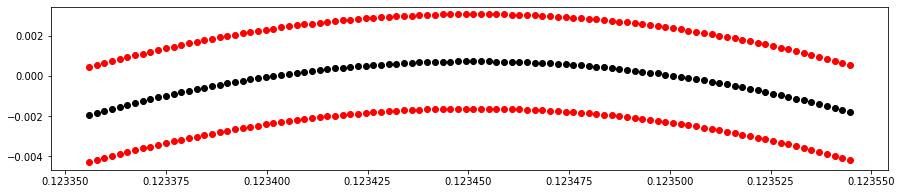

STD: 3.57745820015e-06
OLS: 2.58985902321e-06
WLS: 2.58986019886e-06


In [27]:
# Estimate frequency uncertainty from one signal using error propagation
# Noise sigma is assumed to be known
# For frequency, gradient can't be computed directry, since frequency is estimated as argmax problem
# In this case, for several frequencies near expected maximum location, corresponding DTFT amplitudes are computed
# A parabola can be then fitted and standart errors for coefficient can be estimated
# Error propagation can be used for each frequency value, then weighted fit can be used
# In this example OLS and WLS are used from statmodels library
# Note, such frequency uncertainty estimation is not particularly accurate
# It depends on selected grid of frequencies and might over/under estimate
# Still, the order of magnitude can be somewhat meaningful

# Set a grid of frequencies near expected maximum
# Note, here ffrft grid is used for the 1st signal in TbT
# Here, 100 points near maximum are used, number of points should be increased/decreased for larger/smaller noise
size = 50
position, *_ = f.ffrft_bin.to(torch.int32)
grid = f.ffrft_get_grid()
grid = grid[position - size : position + size]

# Set signal
signal = torch.zeros(length, dtype=dtype, device=device)
signal, *_ = tbt
signal.requires_grad_(True)

# Set covariance matrix
m = std**2 + torch.zeros(length, dtype=dtype, device=device)
m = torch.diag(m)

# Amplitude (log10)
def get_amplitude(frequency, signal):
    c = 2.0/win.total*torch.sum(torch.cos(2.0*numpy.pi*frequency*time)*signal*win.data)
    s = 2.0/win.total*torch.sum(torch.sin(2.0*numpy.pi*frequency*time)*signal*win.data)
    return torch.log10(torch.sqrt(c*c + s*s))

# Compute amplitude and weight for each frequency
X = []
y = []
w = []
for frequency in grid:
    X.append([frequency.cpu().item()**2, frequency.cpu().item(), 1.0])
    a = get_amplitude(frequency, signal)
    a.backward()
    g = signal.grad
    y.append(a.cpu().item())
    w.append(1/torch.dot(g, torch.matmul(m, g)).detach().cpu().item())
    signal.grad = None

# Note, weights are close to one, i.e. OLS and WLS should be close
min(w)/max(w)

# Plot amplitudes
plt.figure(figsize=(15, 3))
plt.scatter(grid.cpu(), y - numpy.sqrt(1/numpy.array(w)), c='red')
plt.scatter(grid.cpu(), y, c='black')
plt.scatter(grid.cpu(), y + numpy.sqrt(1/numpy.array(w)), c='red')
plt.show()

# Fit
from statsmodels.api import OLS, WLS
ols = OLS(y, X).fit()
wls = WLS(y, X, weights=numpy.array(w)).fit()

# Print results
print(f'STD: {s_f:<16.12}')

a, b, c = ols.params
s_a, s_b, s_c = ols.bse
sigma = 1.0/(2.0*a**2)*numpy.sqrt(b**2*s_a**2+a**2*s_b**2)
print(f'OLS: {sigma:<16.12}')

a, b, c = wls.params
s_a, s_b, s_c = ols.bse
sigma = 1.0/(2.0*a**2)*numpy.sqrt(b**2*s_a**2+a**2*s_b**2)
print(f'WLS: {sigma:<16.12}')

# Note, this uncertainty estimation can be used to do weighted fit for different BPMs

In [28]:
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.278e+09
Date:                Fri, 26 Nov 2021   Prob (F-statistic):               0.00
Time:                        09:59:10   Log-Likelihood:                 1455.9
No. Observations:                 100   AIC:                            -2906.
Df Residuals:                      97   BIC:                            -2898.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -2.906e+05      4.311  -6.74e+04      0.0

In [29]:
print(wls.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.277e+09
Date:                Fri, 26 Nov 2021   Prob (F-statistic):               0.00
Time:                        09:59:11   Log-Likelihood:                 1456.0
No. Observations:                 100   AIC:                            -2906.
Df Residuals:                      97   BIC:                            -2898.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -2.906e+05      4.312  -6.74e+04      0.0

# Example-21: Generation and identification of harmonics

In [30]:
# For phase space of dimension 2N, quasiperiodic contains N fundamental frequencies
# Other harmonics are combinations of fundamental basis

# Generate harmonics (real signal with sampling rate equal to one)
order = 2
basis = [0.12, 0.31]
print()
for key, value in Frequency.harmonics(order, basis).items():
    print(key, value)

# Identify harmonics
order = 2
basis = [0.12, 0.31]
frequencies = Frequency.harmonics(order, basis).values()
print()
for key, value in Frequency.identify(order, basis, frequencies).items():
    print(key, value)


(0, 1) 0.31
(1, 0) 0.12
(0, 2) 0.38
(1, -1) 0.19
(1, 1) 0.43
(2, 0) 0.24

(0, 1) [0.31, 0.31, 0.0]
(1, 0) [0.12, 0.12, 0.0]
(0, 2) [0.38, 0.38, 0.0]
(1, -1) [0.19, 0.19, 0.0]
(1, 1) [0.43, 0.43, 0.0]
(2, 0) [0.24, 0.24, 0.0]


# Example-22: Frequency fit (task)

In [31]:
# In this example frequency (and its spread) is estimated for each signal using OLS/WLS fit
# Fit is performed using DTFT spectrum points near the expected maximum

# These estimations are compared with estimations from multiple noise realizations
# And with estimations from time shifted signals

In [32]:
# Compute reference frequency
# Note, without noise, frequencies for different BPMs are equal to machine precision

# Set parameters (signal length, data type and device)
length = 4096
dtype = torch.float64
device = 'cpu'

# Set window
win = Window(4096, 'cosine_window', 2.0, dtype=dtype, device=device)

# Load TbT
ref = Data.from_file(54, win, '../virtual_tbt.npy')

# Compute frequency
f = Frequency(ref)
f('parabola')
m_ref, s_ref = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()

# Print results
print(f'{m_ref:<16.12}')
print(f'{s_ref:<16.12}')

0.461485904416  
1.07834392788e-16


In [33]:
# Set noise parameters

# All BPMs have different noise sigma
std = 1.0E-4*(4.0*torch.rand(54) + 1.0)

# One BPM has increased noise level
std[0] = 3.0E-3

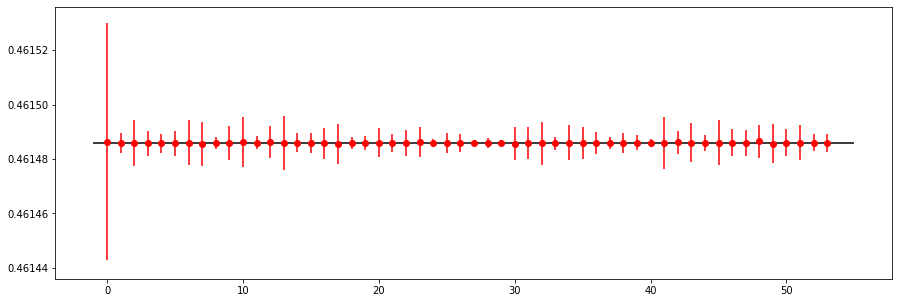

In [34]:
# Estimate spread for different noise realizations

# Iterate over noise realizations

table = []
count = 1024

for _ in range(count):
    win = Window(1024, 'cosine_window', 1.0, dtype=dtype, device=device)
    tbt = Data.from_tensor(win, ref.data[:, :len(win)])
    Data.add_noise(tbt.data, std)
    tbt.reset()
    f = Frequency(tbt)
    f('parabola')
    table.append(f.frequency)

table = torch.stack(table)

# Set mean and spread values for each BPM

m1, s1 = table.mean(0).cpu(), table.std(0).cpu()

# Plot results

plt.figure(figsize=(15, 5))
plt.errorbar(range(54), m1, yerr=s1, c='red', fmt='o')
plt.ylim((m_ref - 5.0E-5, m_ref + 5.0E-5))
plt.hlines(m_ref, -1, 55, colors='black')
plt.show()

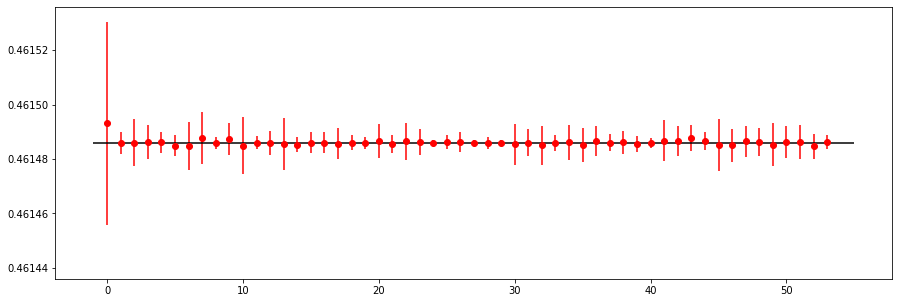

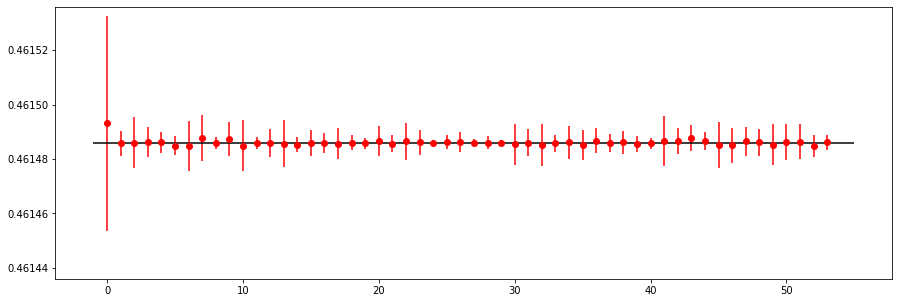

In [35]:
# Estimate spread from time shifted signals

# Load data

win = Window(4096, dtype=dtype, device=device)
ref = Data.from_tensor(win, torch.tensor(numpy.load('../virtual_tbt.npy')))
Data.add_noise(ref.data, std)
ref.reset()

# Iterate over signals

table = []

for idx in range(ref.size):
    tbt = ref.make_matrix(idx, 1024, 16, 'cosine_window', 1.0)
    f = Frequency(tbt)
    f('parabola')
    table.append(f.frequency)

table = torch.stack(table)

# Set mean and spread values for each BPM

m2, s2 = table.mean(1).cpu(), table.std(1).cpu()

# Plot results

plt.figure(figsize=(15, 5))
plt.errorbar(range(54), m2, yerr=s2, c='red', fmt='o')
plt.ylim((m_ref - 5.0E-5, m_ref + 5.0E-5))
plt.hlines(m_ref, -1, 55, colors='black')
plt.show()

# Set mean and spread values for each BPM (peak-to-peak)

f_min = table.min(1).values
f_max = table.max(1).values

m2 = table.mean(1).cpu()
s2 = 1/4.0*(f_max - f_min)

# Plot results

plt.figure(figsize=(15, 5))
plt.errorbar(range(54), m2, yerr=s2, c='red', fmt='o')
plt.ylim((m_ref - 5.0E-5, m_ref + 5.0E-5))
plt.hlines(m_ref, -1, 55, colors='black')
plt.show()

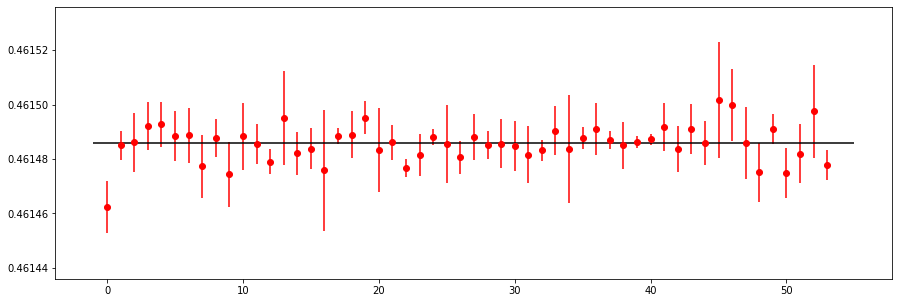

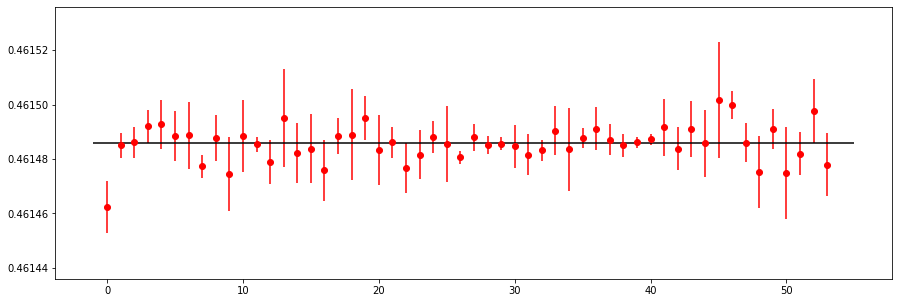

In [36]:
# Estimate spread from fit

# Load data

win = Window(1024, 'cosine_window', 2.0, dtype=dtype, device=device)
tbt = Data.from_tensor(win, torch.tensor(numpy.load('../virtual_tbt.npy')[:, :len(win)]))
Data.add_noise(tbt.data, std)
tbt.reset()

# Compute frequencies

f = Frequency(tbt)
f('parabola')

# Fit (ols)

out = f.task_fit(window=True, size=32, mode='ols')

# Set fitted frequencies and spread

m3, s3 = out.T

plt.figure(figsize=(15, 5))
plt.errorbar(range(54), m3, yerr=s3, c='red', fmt='o')
plt.ylim((m_ref - 5.0E-5, m_ref + 5.0E-5))
plt.hlines(m_ref, -1, 55, colors='black')
plt.show()

# Fit (wls)

out = f.task_fit(window=True, size=32, mode='wls', std=std)

# Set fitted frequencies and spread

m3, s3 = out.T

plt.figure(figsize=(15, 5))
plt.errorbar(range(54), m3, yerr=s3, c='red', fmt='o')
plt.ylim((m_ref - 5.0E-5, m_ref + 5.0E-5))
plt.hlines(m_ref, -1, 55, colors='black')
plt.show()

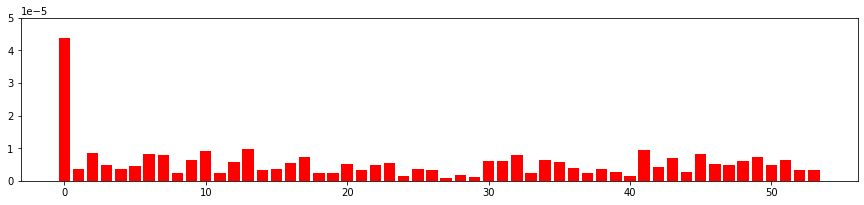

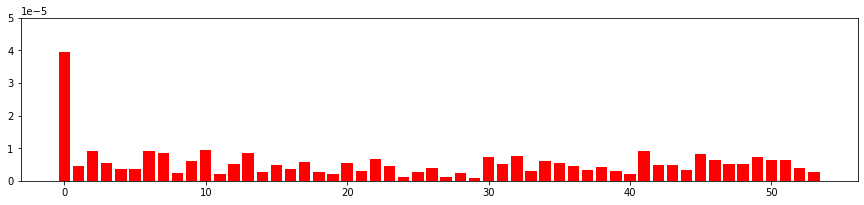

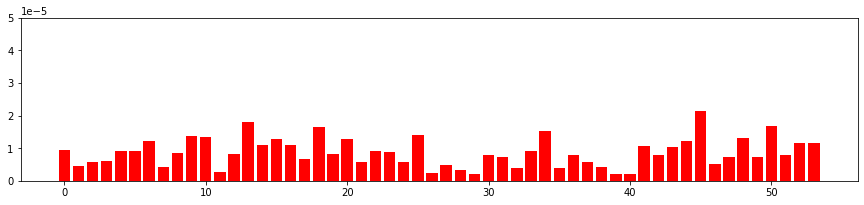

In [37]:
# Compare

plt.figure(figsize=(15, 3))
plt.bar(range(54), s1, color='red')
plt.ylim((0, 5.0E-5))
plt.show()

plt.figure(figsize=(15, 3))
plt.bar(range(54), s2, color='red')
plt.ylim((0, 5.0E-5))
plt.show()

plt.figure(figsize=(15, 3))
plt.bar(range(54), s3, color='red')
plt.ylim((0, 5.0E-5))
plt.show()

In [38]:
# Compare direct mean
print(abs(m_ref - m1.mean().cpu().item()))
print(abs(m_ref - m2.mean().cpu().item()))
print(abs(m_ref - m3.mean().cpu().item()))

4.835197076058506e-09
1.621369289384056e-07
2.944985172947945e-07


In [39]:
# Fit frequency for all BPMs

from statsmodels.api import OLS, WLS

X = numpy.ones(54).reshape(1, 54).T
y = m1.numpy()
w = (1/s1**2).cpu().numpy()

ols1 = OLS(y, X).fit()
wls1 = WLS(y, X, w).fit()

print(f'ols: err={abs(m_ref - ols1.params.item()):12.8}, std={ols1.bse.item():12.8}')
print(f'wls: err={abs(m_ref - wls1.params.item()):12.8}, std={wls1.bse.item():12.8}')

ols: err=4.835197e-09, std=2.393607e-08
wls: err=1.7125251e-08, std=1.1893899e-08


In [40]:
# Fit frequency for all BPMs using 'shifted' weights

from statsmodels.api import OLS, WLS

X = numpy.ones(54).reshape(1, 54).T
y = m2.numpy()
w = (1/s2**2).cpu().numpy()

ols2 = OLS(y, X).fit()
wls2 = WLS(y, X, w).fit()

print(f'ols: err={abs(m_ref - ols2.params.item()):12.8}, std={ols2.bse.item():12.8}')
print(f'wls: err={abs(m_ref - wls2.params.item()):12.8}, std={wls2.bse.item():12.8}')

ols: err=1.6213693e-07, std=1.5736229e-07
wls: err=1.0408282e-08, std=5.2133059e-08


In [41]:
# Fit frequency for all BPMs using 'fitted' weights

from statsmodels.api import OLS, WLS

X = numpy.ones(54).reshape(1, 54).T
y = m3.numpy()
w = (1/s3**2).cpu().numpy()

ols3 = OLS(y, X).fit()
wls3 = WLS(y, X, w).fit()

print(f'ols: err={abs(m_ref - ols3.params.item()):12.8}, std={ols3.bse.item():12.8}')
print(f'wls: err={abs(m_ref - wls3.params.item()):12.8}, std={wls3.bse.item():12.8}')

ols: err=2.9449852e-07, std=9.2328633e-07
wls: err=4.0200152e-07, std=5.9873974e-07


# Example-23: Envelope and instantaneous frequency

In [42]:
# In this example DHT is used to compute signal envelope and instantaneous frequency

In [43]:
# Set test signal

length = 8192
dtype = torch.float64
device = 'cpu'

t = torch.linspace(1, length, length, dtype=dtype, device=device)
s = torch.exp(-0.0001*t*(1 + 0.25*torch.cos(2*numpy.pi*0.001*t)))*torch.cos(2.0*numpy.pi*0.12345*t).unsqueeze(0)

# Compute DHT
dht = Frequency.dht(s)

# Compute envelope
envelope = dht.abs()

# Compute instantaneous frequency
# Note, length is reduced by one
frequency = 1/(2.0*numpy.pi)*(dht[:, :-1]*dht[:, 1:].conj()).angle()

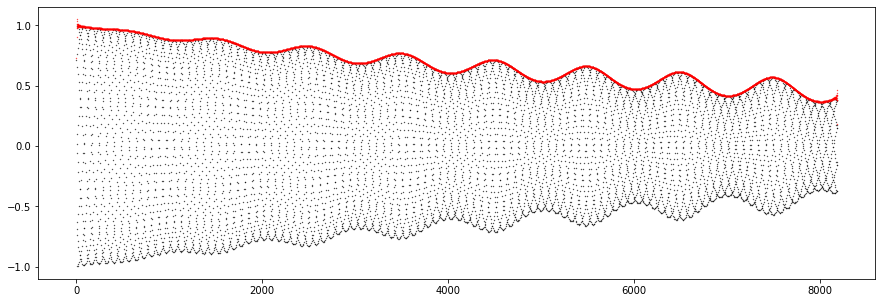

In [44]:
# Plot signal and envelope
# Note, result is not accurate at both ends
plt.figure(figsize=(15,5))
plt.scatter(range(length), s[0].cpu().numpy(), c='black', s=0.1)
plt.scatter(range(length), envelope[0].cpu().numpy(), c='red', s=0.1)
plt.show()

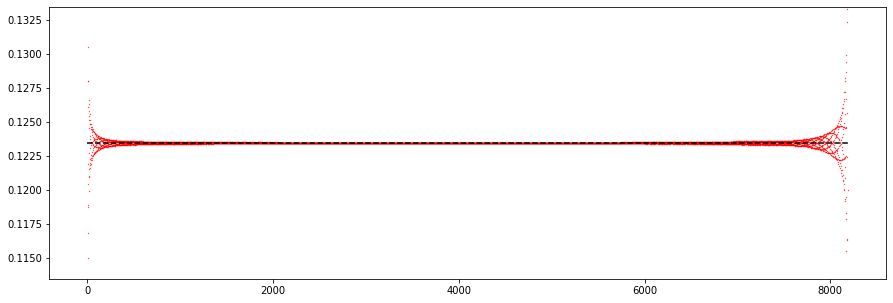

In [45]:
# Plot instantaneous frequency
# Note, result is not accurate at both ends
plt.figure(figsize=(15,5))
plt.ylim(0.12345-0.01, 0.12345+0.01)
plt.scatter(range(length-1), frequency[0].cpu().numpy(), c='red', s=0.1)
plt.hlines(0.12345, 1, length, color='black', linestyles='dashed')
plt.show()

# Example-24: Autocorrelation

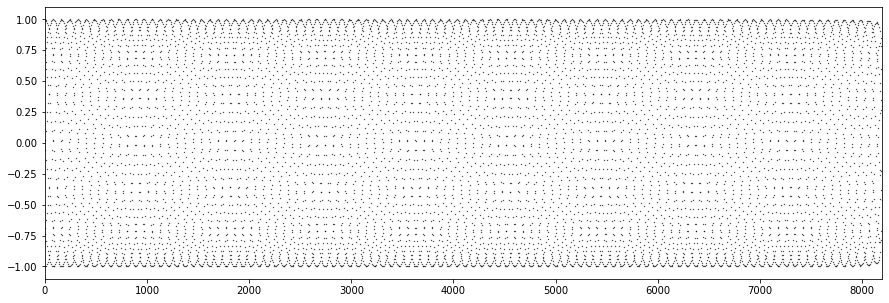

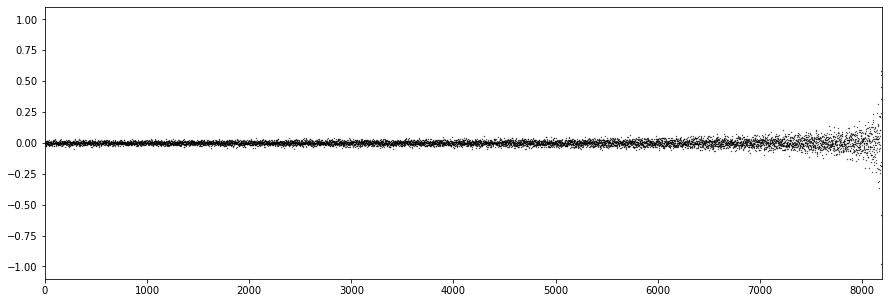

In [46]:
# Compute autocorrelation for random noise and harmonic

length = 8192
dtype = torch.float64
device = 'cpu'

s = torch.cos(2.0*numpy.pi*0.12345*torch.linspace(1, length, length, dtype=dtype, device=device)).unsqueeze(0)
auto = Frequency.autocorrelation(s)
plt.figure(figsize=(15, 5))
plt.scatter(range(length), auto[0].cpu().numpy(), c='black', s=0.1)
plt.xlim(0, length + 1)
plt.ylim(-1.1, 1.1)
plt.show()

s = torch.randn((1, length), dtype=dtype, device=device)
auto = Frequency.autocorrelation(s)
plt.figure(figsize=(15, 5))
plt.scatter(range(length), auto[0].cpu().numpy(), c='black', s=0.1)
plt.xlim(0, length + 1)
plt.ylim(-1.1, 1.1)
plt.show()